# Totally Accurate Warhammer Simulator - II
Memoirs of the Old World

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
import scipy.signal as sig
import scipy.stats as stats
from fractions import Fraction
import matplotlib.pyplot as plt

In [2]:
sns.set_theme()

# Functions

In [3]:
def roll_to_hit(attackers_ws, defenders_ws):
    
    if defenders_ws < attackers_ws:
        if defenders_ws*2 < attackers_ws:
            return Fraction(5, 6)
        return Fraction(4, 6)
    
    if attackers_ws < defenders_ws:
        if attackers_ws*2 < defenders_ws:
            if attackers_ws*2+3 < defenders_ws:
                return Fraction(1, 6)
            return Fraction(2, 6)
        return Fraction(3, 6)
    
    return Fraction(3, 6)

In [4]:
def roll_to_shoot(attackers_bs, modifier):
    
    hit_score = attackers_bs - 3 + modifier
    
    if -3 < hit_score < 3:
        return Fraction(hit_score + 3, 6)
    
    if 3 <= hit_score:
        return Fraction(5, 6)
    
    if -6 < hit_score <= -3:
        return {-3: Fraction(1, 12),
                -4: Fraction(1, 18),
                -5: Fraction(1, 36)}.get(hit_score)

    return Fraction(0, 6)

In [5]:
def roll_to_wound(attackers_s, defenders_t):

    if defenders_t < attackers_s:
        if (attackers_s - defenders_t) > 1:
            return Fraction(5, 6)
        return Fraction(4, 6)
    
    if attackers_s < defenders_t:
        if (defenders_t - attackers_s) > 1:
            return Fraction(1, 6)
        return Fraction(2, 6)
    
    return Fraction(3, 6)

In [6]:
def roll_to_save(attackers_s, defenders_save):

    final_save = defenders_save
    
    if attackers_s > 3:
        final_save = defenders_save - (attackers_s - 3)
        
    if final_save < 1:
        return 0

    if final_save > 4:
        return Fraction(5, 6)
    
    return Fraction(final_save, 6)

In [7]:
# Treating a Ward of 7 as -
def roll_to_ward(defenders_ward):
    
    if defenders_ward < 4:
        return Fraction(3, 6)
    
    return Fraction(7 - defenders_ward, 6)

In [8]:
D6 = np.repeat(Fraction(1, 6), 6)
TWO_D6 = sig.convolve(D6, D6)
def roll_to_break(defenders_ld, wounds, allies):
    effective_ld = defenders_ld - wounds + allies
    if effective_ld < 2:
        effective_ld = 2
    elif effective_ld > 12:
        effective_ld = 12
    return TWO_D6[effective_ld-1:].sum()

In [9]:
def p_wound_melee(a_ws, d_ws, a_s, d_t, d_save=0, d_ward=7):
    p_hit = roll_to_hit(a_ws, d_ws)
    p_wound = roll_to_wound(a_s, d_t)
    p_save = roll_to_save(a_s, d_save)
    p_ward = roll_to_ward(d_ward)
    p = p_hit * p_wound * (1-p_save) * (1-p_ward)
    return p

In [10]:
def p_wound_range(a_bs, modifier, w_s, d_t, d_save=0, d_ward=7):
    p_shoot = roll_to_shoot(a_bs, modifier)
    p_wound = roll_to_wound(w_s, d_t)
    p_save = roll_to_save(w_s, d_save)
    p_ward = roll_to_ward(d_ward)
    p = p_shoot * p_wound * (1-p_save) * (1-p_ward)
    return p

In [11]:
def effective_wound_dist(attacks, p_wound, defender_ld, defender_allies=0):
    wound_dist = stats.binom(attacks, p_wound)
    acc = [(0, 0, wound_dist.pmf(k=0))]
    for k in range(1, attacks+1):
        p_k_wounds = wound_dist.pmf(k)
        p_break = roll_to_break(defender_ld, k, defender_allies)

        retreat_dist = stats.binom(k, 1/6)
        p_no_retreat = p_k_wounds*((1-p_break) + p_break*retreat_dist.pmf(0))
        acc.append((k, 0, p_no_retreat))

        for retreat in range(1, k+1):
            acc.append((k-retreat, retreat, p_k_wounds*p_break*retreat_dist.pmf(retreat)))
            
    return (pd.DataFrame(acc, columns=["wounds", "retreats", "prob"])
            .set_index(["wounds", "retreats"]))

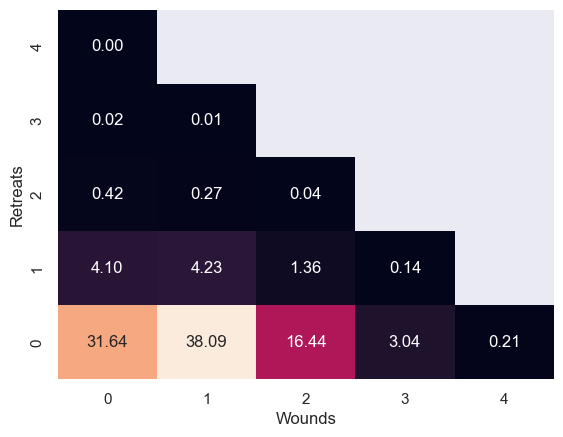

In [12]:
data = (effective_wound_dist(4, float(p_wound_melee(3, 3, 3, 3)), 7)
        .pivot_table(index="retreats", columns="wounds", values="prob")
        .sort_index(ascending=False))

f, ax = plt.subplots(1, 1)
sns.heatmap(data*100, ax=ax, annot=True, fmt=".2f", cbar=False)
ax.set_xlabel("Wounds")
ax.set_ylabel("Retreats");

### Plotting Functions

In [13]:
def melee_wound_distribution(attacker, defender, plot=True):
    p_wound = p_wound_melee(attacker["ws"], defender["ws"], attacker["s"], defender["t"], 
                            defender["save"], defender["ward"])
    
    wound_dist = effective_wound_dist(attacker["a"], float(p_wound), defender["ld"])
    data = (wound_dist
            .pivot_table(index="retreats", columns="wounds", values="prob")
            .sort_index(ascending=False))
    
    if not plot:
        return data

    f, ax = plt.subplots(1, 1)
    ax.set_title("{} vs {}\n"
                 "[WS:{}, S:{}] vs [WS:{}, T:{}, Save:{}, Ward:{}, Leadership: {}]\n"
                 "{} Attacks, (0 Wounds, 0 Retreats = {:.2f}%)"
                 .format(attacker["name"], defender["name"],
                         attacker["ws"], attacker["s"],
                         defender["ws"], defender["t"],
                         "-" if defender["save"] == 0 else "+{}".format(defender["save"]),
                         "-" if defender["ward"] == 7 else "{}+".format(defender["ward"]),
                         defender["ld"],
                         attacker["a"], wound_dist.loc[0, 0]["prob"]*100))
    sns.heatmap(data*100, ax=ax, annot=True, fmt=".2f", cbar=False)
    return (f, ax)

In [14]:
def range_wound_distribution(attacker, defender, plot=True):
    p_wound = p_wound_range(attacker["bs"], attacker["rh"], attacker["rs"], defender["t"], 
                            defender["save"], defender["ward"])
    
    wound_dist = effective_wound_dist(attacker["ra"], float(p_wound), defender["ld"])
    data = (wound_dist
            .pivot_table(index="retreats", columns="wounds", values="prob")
            .sort_index(ascending=False))

    if not plot:
        return data
    
    f, ax = plt.subplots(1, 1)
    ax.set_title("{} vs {}\n"
                 "[BS:{}, S:{}, M:{}] vs [T:{}, Save:{}, Ward:{}, Leadership: {}]\n"
                 "{} Attacks, (0 Wounds, 0 Retreats = {:.2f}%)"
                 .format(attacker["name"], defender["name"],
                         attacker["bs"], attacker["rs"], attacker["rh"],
                         defender["t"],
                         "-" if defender["save"] == 0 else "+{}".format(defender["save"]),
                         "-" if defender["ward"] == 7 else "{}+".format(defender["ward"]),
                         defender["ld"],
                         attacker["ra"], wound_dist.loc[0, 0]["prob"]*100))
    sns.heatmap(data*100, ax=ax, annot=True, fmt=".2f", cbar=False)
    return (f, ax)

## Memoir 44 Comparison

In [15]:
m44_dice = 3
inf_dist = stats.multinomial(m44_dice, [Fraction(3, 6), Fraction(1, 6), Fraction(1, 6)])
tan_dist = stats.multinomial(m44_dice, [Fraction(2, 6), Fraction(1, 6), Fraction(2, 6)])
art_dist = stats.multinomial(m44_dice, [Fraction(1, 6), Fraction(1, 6), Fraction(3, 6)])
m44_pmf = (pd.DataFrame(
            [("infantry", h, f, inf_dist.pmf([h, f, m])) for h in range(4) for f in range(4) for m in range(4) if h+f+m == 3] +\
            [("tanks", h, f, tan_dist.pmf([h, f, m])) for h in range(4) for f in range(4) for m in range(4) if h+f+m == 3] +\
            [("artillery", h, f, art_dist.pmf([h, f, m])) for h in range(4) for f in range(4) for m in range(4) if h+f+m == 3],
            columns=["troop", "hits", "flags", "prob"])
            .set_index(["troop", "hits", "flags"]))

Text(0.5, 0.98, '3 attacks (%)')

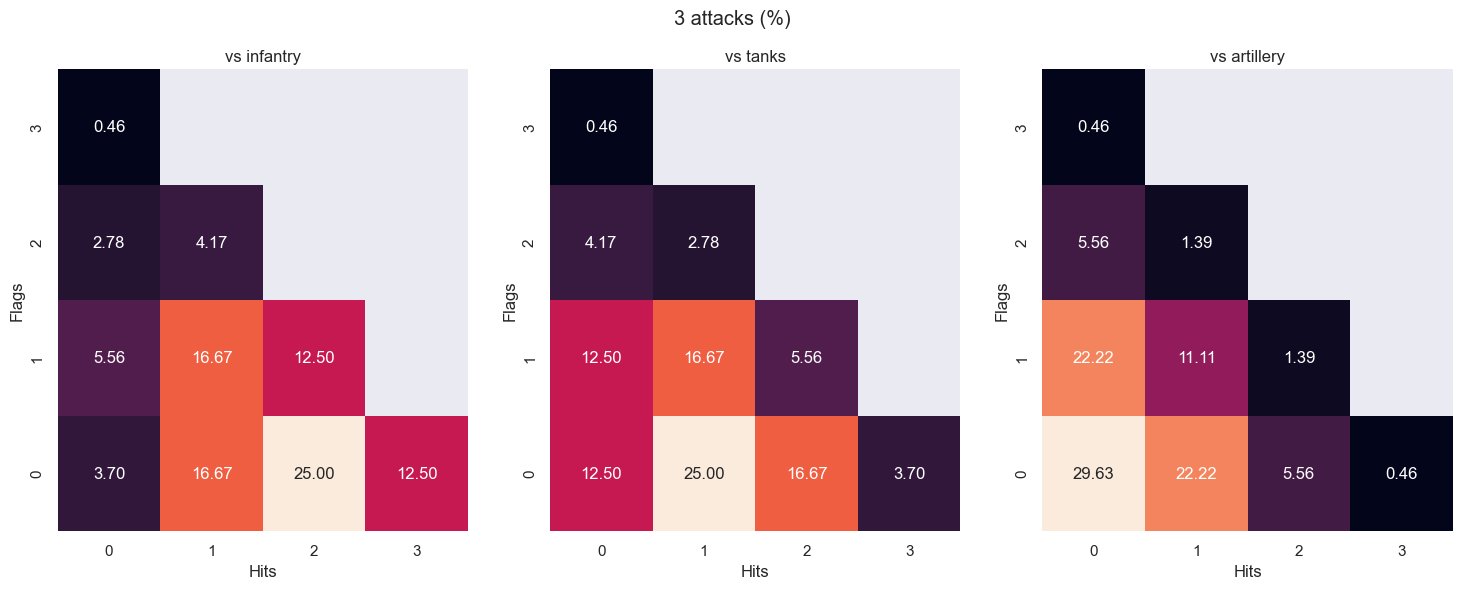

In [16]:
f, axs = plt.subplots(1, 3)
f.set_size_inches(18, 6)

acc = []
for ax, troop in zip(axs, ["infantry", "tanks", "artillery"]):
    data = (m44_pmf.loc[troop]
            .pivot_table(index="flags", columns="hits", values="prob")
            .sort_index(ascending=False))        
    sns.heatmap(data*100, ax=ax, annot=True, fmt=".2f", cbar=False)
    ax.set_xlabel("Hits")
    ax.set_ylabel("Flags")
    ax.set_title("vs {}".format(troop))

f.suptitle("{} attacks (%)".format(m44_dice))

## Memoirs of the Old World

In [17]:
def human():
    return {"name": "Human",
            "a": 4, "ws": 3, "bs": 3,
            "s": 3, "t": 3, "save": 0, "ward":7,
            "ld": 7}

In [18]:
def spearmen(has_extra_ranks=True, has_strength_bonus=False):
    attacks = 8 if has_extra_ranks else 4
    strength = 4 if has_strength_bonus else 3
    return {"name": "Empire Spearmen",
            "a": attacks, "ws": 3, "bs": 3,
            "s": strength, "t": 3,
            "save": 0, "ward": 7,
            "ld": 7}

In [19]:
def orc_boyz():    
    return {"name": "Orc Boyz",
            "a": 3, "ws": 3, "bs": 3,
            "s": 4, "t": 4,
            "save": 1, "ward": 6,
            "ld": 7}

In [20]:
def archers(ranks=4, multiple_shots=False, volley_fire=False, modifier=0):

    if volley_fire:
        attacks = 4 * ranks
        modifier -= 1
    else:
        attacks = 8 if ranks > 1 else 4
        
    if multiple_shots:
        attacks *= 2
        modifier -= 1
        
    return {"name": "Empire Archers",
            "a": 4, "ws": 3, "bs": 3,
            "s": 3, "t": 3,
            "save": 0, "ward": 0,
            "ld": 7,
            "ra": attacks, "rs": 3, "rh": modifier}

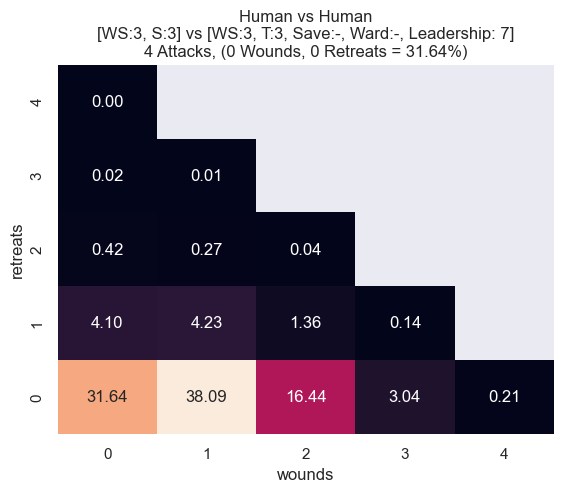

In [21]:
melee_wound_distribution(human(), human());

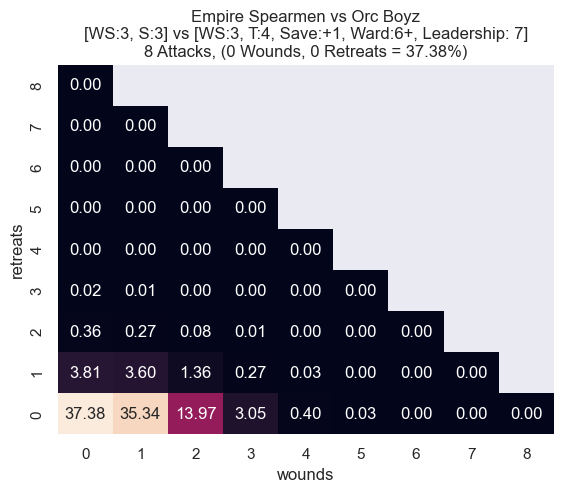

In [22]:
melee_wound_distribution(spearmen(), orc_boyz());

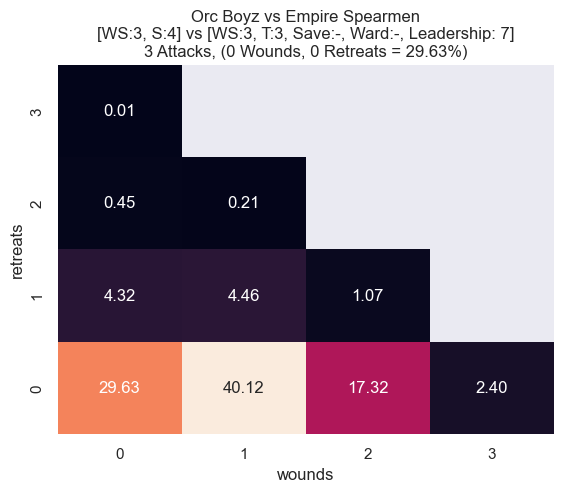

In [23]:
melee_wound_distribution(orc_boyz(), spearmen());

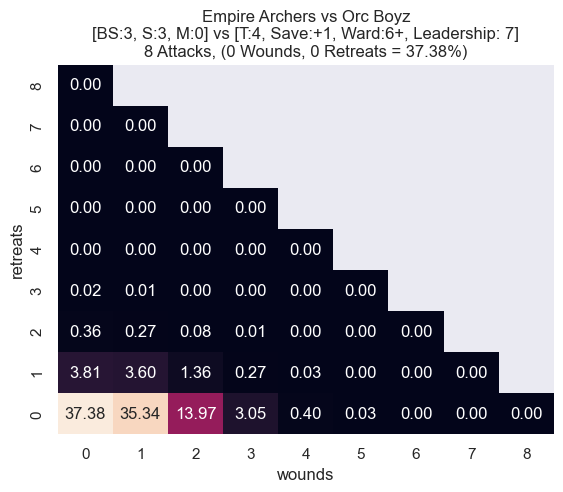

In [24]:
range_wound_distribution(archers(), orc_boyz());

In [25]:
(range_wound_distribution(archers(multiple_shots=True, volley_fire=True), orc_boyz(), False)
 .loc[[0, 1, 2, 3],[0, 1, 2, 3]])

wounds,0,1,2,3
retreats,,,,
0,0.283934,0.329155,0.176734,0.059054
1,0.035447,0.045496,0.026332,0.009363
2,0.004550,0.005266,0.002809,0.000930
3,0.000351,0.000375,0.000186,0.000056
